In [2]:
!pip install numpy
!pip install matplotlib

    100% |████████████████████████████████| 11.5MB 135kB/s ta 0:00:01
  Cache entry deserialization failed, entry ignored
    100% |████████████████████████████████| 3.0MB 390kB/s ta 0:00:011
    100% |████████████████████████████████| 1.1MB 1.0MB/s ta 0:00:01


In [59]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt

In [60]:
class AMM:
    sigma, eta = 0.2, 0.8
    
    def __init__(self, init_a, init_b, init_y):
        self.init_a = init_a
        self.init_b = init_b
        self.init_y = init_y
        
    def mu_function(self, a, b, y):
        sigma, eta = self.sigma, self.eta
        return (a ** (1 - sigma) + b ** (1 - sigma)) ** ((1 - eta) / (1 - sigma)) + y ** (1 - eta)
    
    def get_delta_a(self, delta_y):
        a, b, y = self.init_a, self.init_b, self.init_y
        sigma, eta = self.sigma, self.eta
        
        mu = self.mu_function(a, b, y)
        
        return a - ((mu - (y + delta_y) ** (1 - eta)) ** ((1 - sigma) / (1 - eta)) - b ** (1 - sigma)) ** (1 / (1 - sigma)) 
    
    def get_delta_y(self, delta_a):
        a, b, y = self.init_a, self.init_b, self.init_y
        sigma, eta = self.sigma, self.eta
        
        mu = self.mu_function(a, b, y)
        
        return -(mu - ((a + delta_a) ** (1 - sigma) + b ** (1 - sigma)) ** ((1 - eta) / (1 - sigma))) ** (1 / (1 - eta)) + y
   
    def get_delta_b(self, delta_a):
        a, b, y = self.init_a, self.init_b, self.init_y
        sigma, eta = self.sigma, self.eta
        
        mu = self.mu_function(a, b, y)
        
        return -((mu - y ** (1 - eta)) ** ((1 - sigma) / (1 - eta)) - (a + delta_a) ** (1 - sigma)) ** (1 / (1 - sigma)) + b

<IPython.core.display.Javascript object>


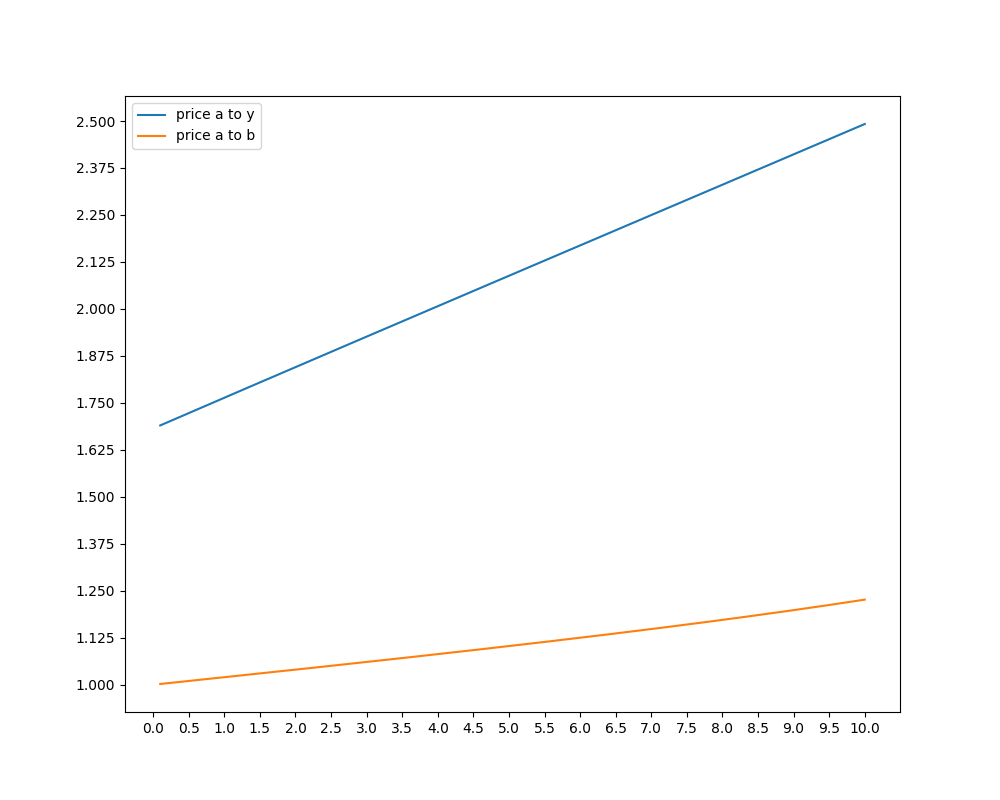

In [81]:
amm = AMM(10, 10, 10)
x_series = np.linspace(0.1, 10, 1000)

a_y = [amm.get_delta_a(x) for x in x_series]
y_a = [amm.get_delta_y(x) for x in x_series]
b_a = [amm.get_delta_b(x) for x in x_series]

plt.rcParams["figure.figsize"] = (10,8)
plt.yticks(np.linspace(0, 3, 25))
plt.xticks(np.linspace(0, 10, 21))
plt.plot(x_series, x_series/y_a)
plt.plot(x_series, x_series/b_a)
plt.legend(['price a to y', 'price a to b'])
plt.savefig('price_chart.png')

$$ \Lambda(a, b, y) = ((a^{1-\sigma} + b^{1-\sigma})^{\frac{1}{1-\sigma}})^{1-\eta} + y^{1-\eta}